# Customer Churn Prediction with IBM Db2 Warehouse using sklearn

__Introduction__

This notebook presents a churn prediction use case using anonymized customer data from a phone operator. It uses IBM Db2 Warehouse and runs on a Python3 kernel. Some visualizations are plotted locally using seaborn and matplotlib, modelisation is done with sklearn. Data is accessed to using ibmdbPy. The ibmdbPy package provides methods to read data from, write data to, and sample data from a Db2 database. It also provides access methods for in-database analytic or geospatial functions. For more information abour ibmdbpy, please follow this [link](https://www.ibm.com/support/knowledgecenter/fr/SSFMBX/com.ibm.swg.im.dashdb.analytics.doc/doc/analyze_python.html).

Our goal is to accurately predict whether a customer is going to end his/her contract (labeled as positive,1). We prefer to send a commercial email to someone who intends to keep her contract but is labeled as willing to end it (false positive) rather than to overlook the opportunity to prevent a customer from ending her contract (false negative), but also care not to overwhelm our customers with commercials or to lose money by proposing special offers to too many people. Our optimization objective will here be to maximize recall. We will also look at other classic metrics too.

__Contents__
1. Get ready
2. Explore the data
3. Prepare the data
4. Build your model on the training set
5. Fine tune your hyperparameters on the validation set
6. Assess your model performance on the test set
7. Save your model for future use


__Requirements:__

* connection to Db2 Warehouse
* ibmdbpy for accessing data from Db2 Warehouse
* Python 3 including pandas, sklearn, joblib

## 1. Get ready

__Imports__

Lets start by loading ibmdbPy. We will also need to import JayDeBeAPI package to connect to the database using JDBC from ibmdbPy.

In [1]:
import jaydebeapi
from ibmdbpy import IdaDataBase
from ibmdbpy import IdaDataFrame

We import pandas for data exploration and transformation, sklearn for modelisation and evaluation, joblib for model persistence. We will also plot some graphs with matplotlib.

In [71]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from joblib import dump, load
from sklearn.model_selection import train_test_split

#from pyspark.ml.linalg import Vectors

__Enter your database credentials__

In [3]:
#Enter the values for you database connection
dsn_database = "BLUDB"            # e.g. "BLUDB"
dsn_hostname = "idax29.svl.ibm.com" # e.g.: "bluemix05.bluforcloud.com"
dsn_port = "50000"                # e.g. "50000"
dsn_uid = "bluadmin"        # e.g. "dash104434"
dsn_pwd = "curymuryfuk"       # e.g. "7dBZ3jWt9xN6$o0JiX!m"

Note : you may get the following message:

HELP: The JDBC driver for IBM Db2 could not be found. Please download the latest JDBC Driver at the following address: 'http://www-01.ibm.com/support/docview.wss?uid=swg21363866' and put the file 'db2jcc.jar' or 'db2jcc4.jar' in the CLASSPATH variable or in a folder that is in the CLASSPATH variable. Alternatively place it in the folder /Users/<user_name>/anaconda3/lib/python3.7/site-packages/ibmdbpy

In this case, follow the steps and don't forget to select the right platform in the menu on IBM's fix catalog. You can check out your CLASSPATH with 
> import os

> print(os.environ["CLASSPATH"])

In [6]:
connection_string='jdbc:db2://'+dsn_hostname+':'+dsn_port+'/'+dsn_database+':user='+dsn_uid+';password='+dsn_pwd+";" 
idadb=IdaDataBase(dsn=connection_string)

Congratulations! You are now connected to Db2 and can perform in-database analytics with ibmpbpy!

As a starter, let's take a quick look at the tables you've got. Documentation for ibmpbpy can be found on this [page](https://pythonhosted.org/ibmdbpy/start.html).

In [7]:
test_df=idadb.show_tables(show_all = True)
test_df.head(5)

,TABSCHEMA,TABNAME,OWNER,TYPE
0,BLUADMIN,CHURN_PROPORTION,BLUADMIN,T
1,BLUADMIN,CI_KM5C_CLUSTERS,BLUADMIN,T
2,BLUADMIN,CI_KM5C_COLUMNS,BLUADMIN,T
3,BLUADMIN,CI_KM5C_COLUMN_STATISTICS,BLUADMIN,T
4,BLUADMIN,CI_KM5C_MODEL,BLUADMIN,T


__Load the data__

Let's use a table which has been pre-populated in Db2 local. It is called SAMPLES.TRAINING. 

In [15]:
# Open an IdaDataFrame
idadf = IdaDataFrame(idadb, 'SAMPLES.TRAINING')
print(type(idadf))

<class 'ibmdbpy.frame.IdaDataFrame'>


In [16]:
# Take a first look at the data
idadf.head()

,CHURN,AREA,VMAIL,VMAIL_MSGS,DAY_MINS,DAY_CALLS,DAY_CHARGE,EVE_MINS,EVE_CALLS,EVE_CHARGE,NIGHT_MINS,NIGHT_CALLS,NIGHT_CHARGE,INTL_MINS,INTL_CALLS,INTL_CHARGE,SVC_CALLS
0,0,415,1,0,139.5,119,23.72,289.3,105,24.59,129.4,97,5.82,13.1,8,3.54,0
1,0,510,1,0,231.8,120,39.41,150.6,106,12.80,269.2,129,12.11,11.6,7,3.13,3
2,0,415,1,0,146.2,55,24.85,261.5,83,22.23,163.2,116,7.34,8.7,3,2.35,3
3,0,415,1,0,187.8,94,31.93,248.6,86,21.13,208.8,124,9.40,10.6,5,2.86,0
4,0,415,0,29,142.3,107,24.19,118.7,56,10.09,240.1,91,10.80,6.6,8,1.78,1


In [ ]:
# To ensure expected behaviors, IdaDataBase instances need to be closed. 
# Closing the IdaDataBase is equivalent to closing the connection: once the connection is closed, it is not possible 
# to use the IdaDataBase instance and any IdaDataFrame instances that were opened on this connection anymore.
idadb.close()
#idadb.reconnect()

How many records do we have? how many features? 

In [18]:
print('Number of records: '+str(len(idadf)))
print('Number of features: '+str(len(idadf.columns)))

Number of records: 3333
Number of features: 17


__Convert into a Pandas DataFrame__

Because we won't be using in-database functions here. We will use scikit-learn locally to build our models.

In [23]:
df = idadf.as_dataframe()
print(type(df))

<class 'pandas.core.frame.DataFrame'>


__Split the data__

We split the data into three datasets: for training, validation and testing. We use the proportions 80%, 10% and 10% so that we keep a relatively high number of examples for training but also have enough examples for the validation and test sets to be representative. Of course these proportions are subjective, you can change them if you want. We have also defined a seed so tht results can be reproduced.

In [50]:
#Isolate label from features
x = df.drop("CHURN", axis=1)
y = df["CHURN"]

# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.70
ratio_val = 0.15
ratio_test = 0.15

# Produces test split.
remaining_x, test_x, remaining_y, test_y = train_test_split(x, y, test_size=ratio_test)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
train_x, val_x, train_y, val_y = train_test_split(remaining_x, remaining_y, test_size=ratio_val_adjusted)

## 2. Explore the data

We only explore the training set.

__Data schema__

Let's see what kind of features we have.

In [51]:
print(train_x.columns)

Index(['AREA', 'VMAIL', 'VMAIL_MSGS', 'DAY_MINS', 'DAY_CALLS', 'DAY_CHARGE',
       'EVE_MINS', 'EVE_CALLS', 'EVE_CHARGE', 'NIGHT_MINS', 'NIGHT_CALLS',
       'NIGHT_CHARGE', 'INTL_MINS', 'INTL_CALLS', 'INTL_CHARGE', 'SVC_CALLS'],
      dtype='object')


Columns include:

- Area : a geographic label, we might wonder which impact this feature has on churn
- VMail: whether voice messages have been left
- VMail_msgs: number of voice messages
- day_mins, eve_mins, night_mins, intl_mins: time spend calling in the day/evening/night/abroad
- day_calls, eve_calls, night_calls, intl_calls: number of calls in each category
- day_charge, eve_charge, night_charge, intl_charge: price charged for each category
- svc_calls: service calls.

Churn is our label : whether the customer resigned his/her phone subscription, this is our target

__Basic statistics__

In [52]:
train_x.describe()

,AREA,VMAIL,VMAIL_MSGS,DAY_MINS,DAY_CALLS,DAY_CHARGE,EVE_MINS,EVE_CALLS,EVE_CHARGE,NIGHT_MINS,NIGHT_CALLS,NIGHT_CHARGE,INTL_MINS,INTL_CALLS,INTL_CHARGE,SVC_CALLS
count,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000
mean,437.483926,0.724818,8.004286,179.562580,100.599228,30.526207,200.264123,100.156880,17.022696,201.026489,100.244749,9.046279,10.222417,4.462066,2.760600,1.560223
std,42.583087,0.446702,13.572908,54.191471,20.112359,9.212579,51.074798,19.809346,4.341327,50.117369,19.635150,2.255309,2.783065,2.458044,0.751434,1.303246
min,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,408.000000,0.000000,0.000000,143.600000,87.000000,24.410000,165.700000,87.000000,14.080000,166.700000,87.000000,7.500000,8.500000,3.000000,2.300000,1.000000
50%,415.000000,1.000000,0.000000,179.300000,101.000000,30.480000,201.000000,101.000000,17.090000,200.500000,101.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,510.000000,1.000000,19.000000,215.900000,114.000000,36.700000,235.000000,113.000000,19.980000,236.300000,114.000000,10.630000,12.000000,6.000000,3.240000,2.000000
max,510.000000,1.000000,51.000000,346.800000,165.000000,58.960000,363.700000,168.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [53]:
train_y.describe()

count    2333.000000
mean        0.146164
std         0.353346
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: CHURN, dtype: float64

We see that there is no missing value in the dataset, which is great.

We have a turnout of roughly 15%, so we must do better than a 85% accuracy (accuracy of a naive classifier which would label all examples as 0 id est customer remains a client).


__Visualisation__

Let's visualize relationships between features using a scatter plot.

NB: Color code is blue if CHURN is 0, red if CHURN is 1.

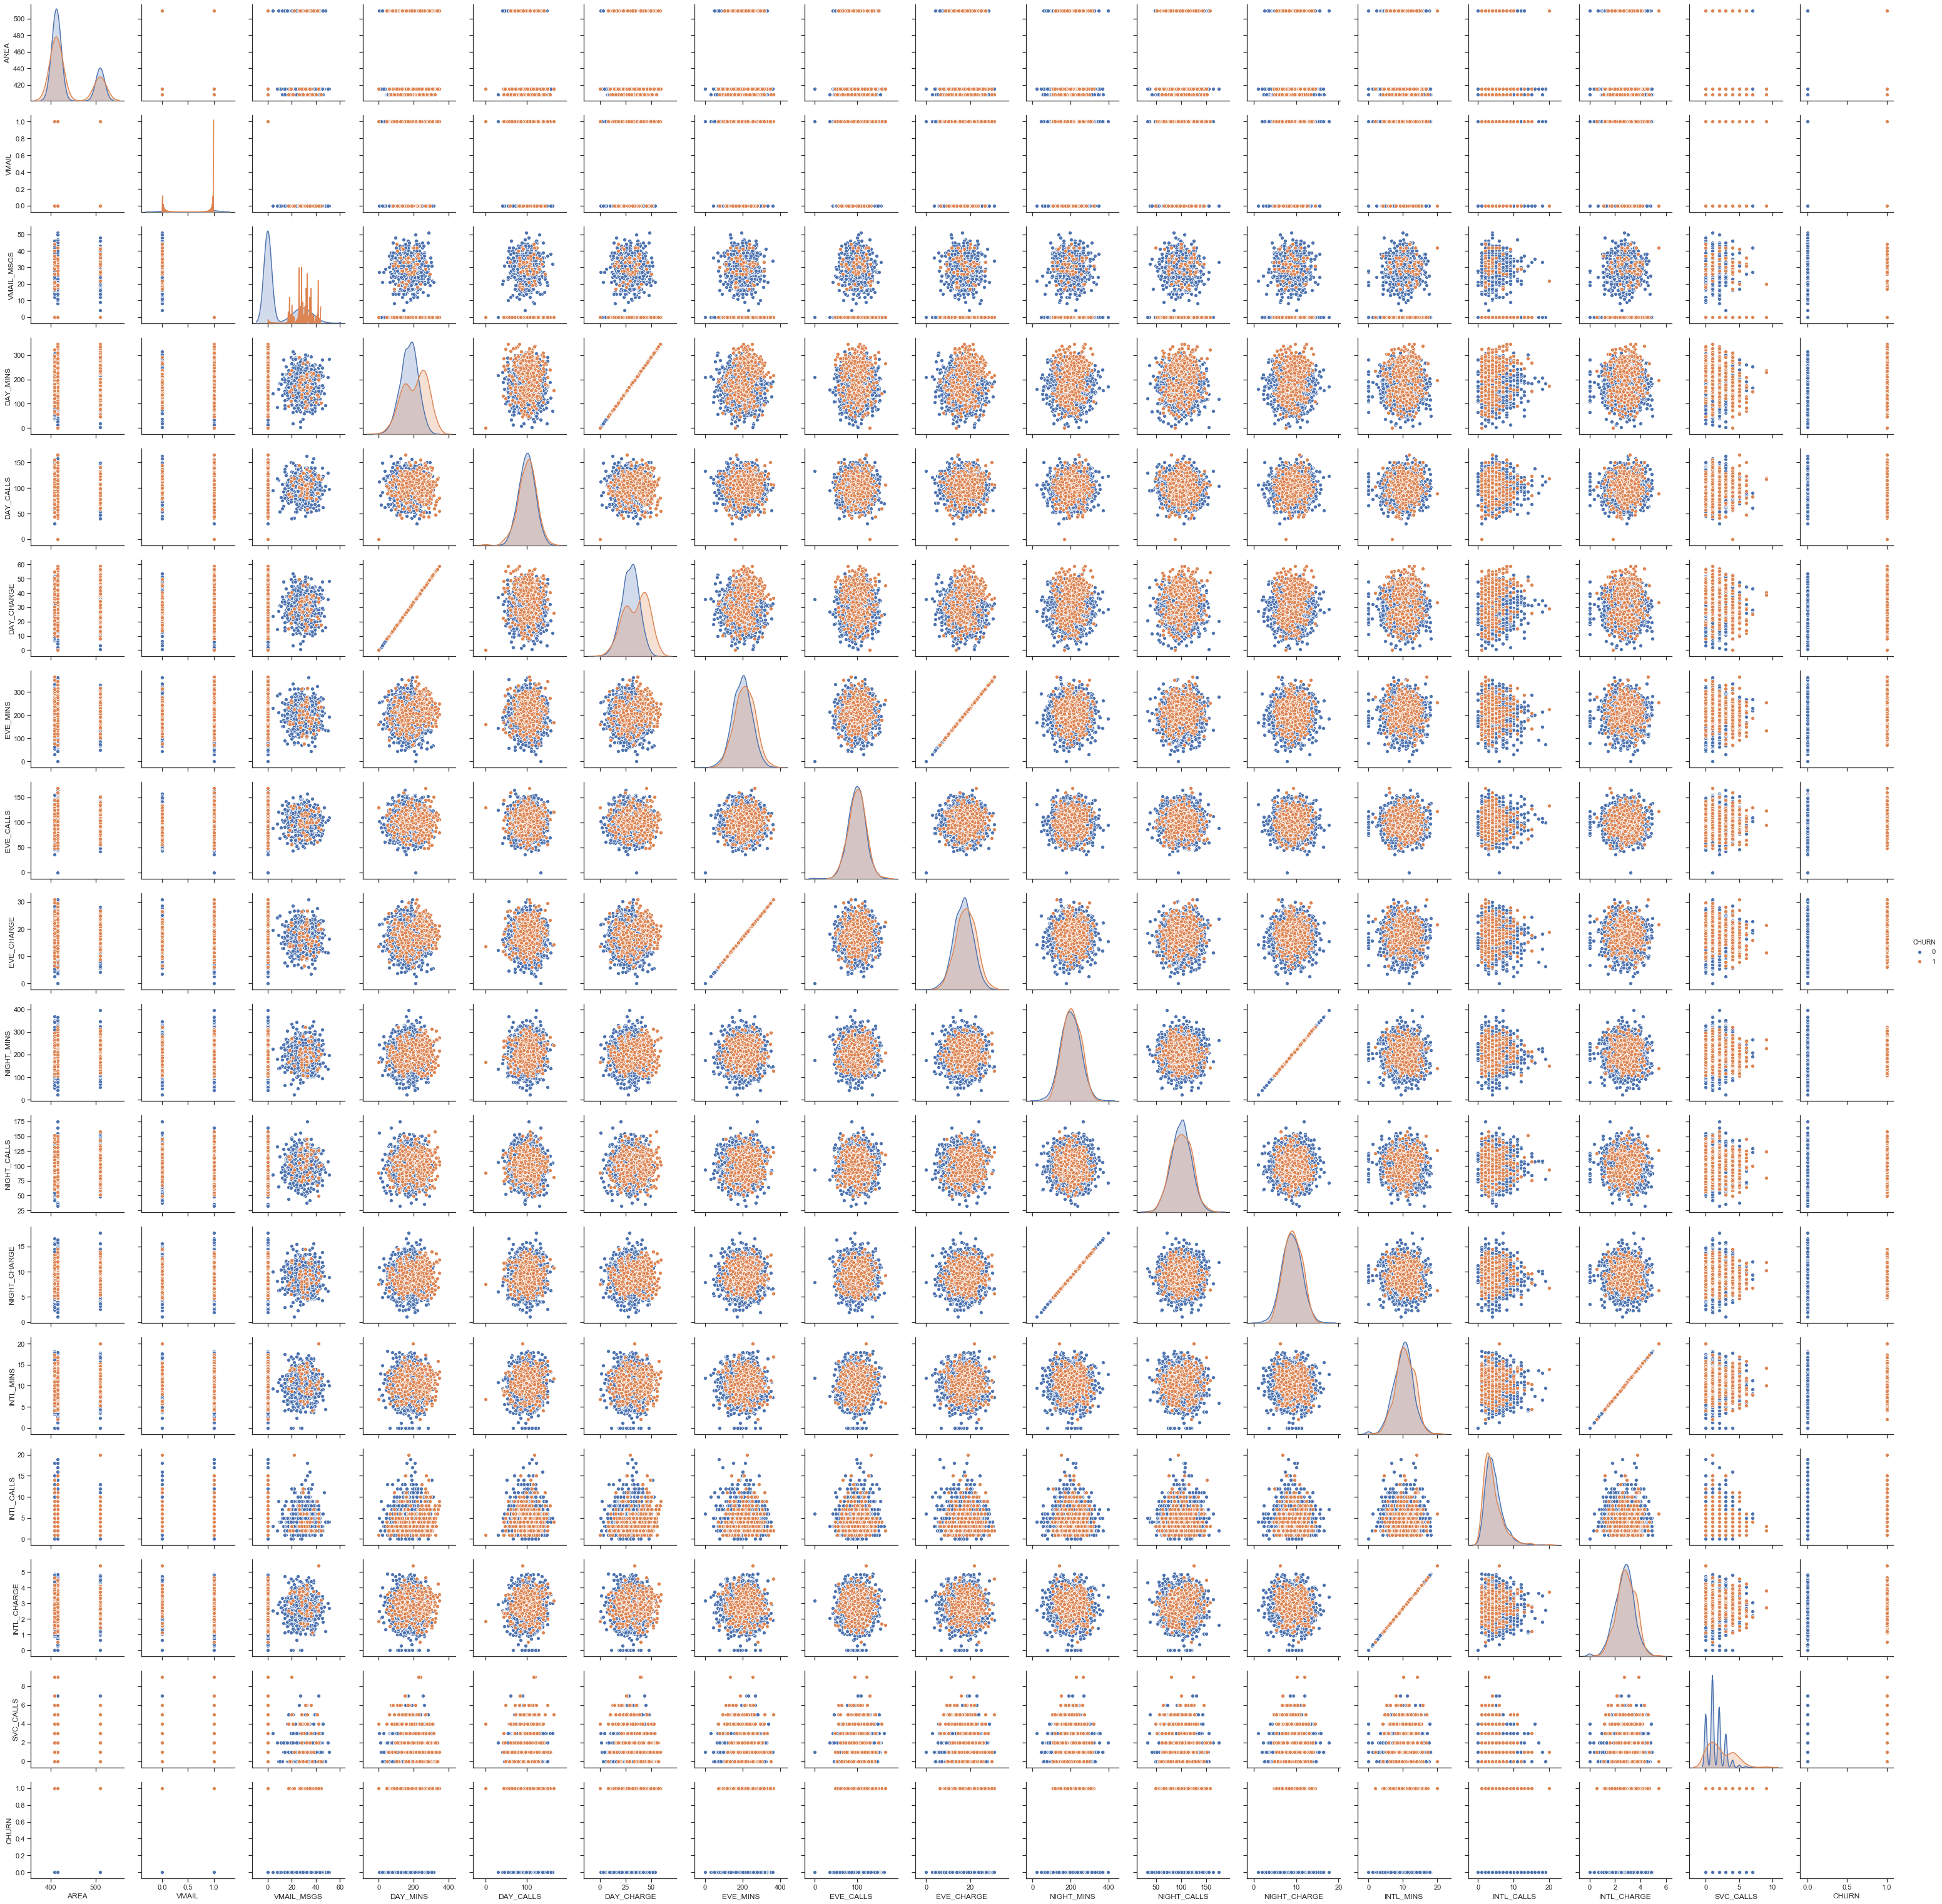

In [54]:
train = train_x.copy()
train["CHURN"] = train_y
sns.set(style="ticks")
sns.pairplot(train, hue='CHURN')

Comments
- most people who have voice mail messages are likely to end their contract, particularly if they receive between 20 and 40 voice messages;
- distribution of number of calls and cumulated time among each category is very similar between classes churn=1 and churn=0. This might make our prediction task hard to perform;
- service calls distributions however differ from class 0 to class 1; 
- area is not a discriminative feauture;
- concentric round patterns tend to appear but the red zone is superimposed with the blue underlying zone, so this might also make prediction hard;
- pricing is linear (simple linear function between time and price, no flat rate or minimum charge).


In [ ]:
## GRID SEARCH



## 4. Train algorithms 

__First try with default options__

Let's define and build a logistic regression model on our training data.

LR default : penalty='l2', dual=False, tol=0.0001, C=1, fit_intercept=True, 
                                        intercept_scaling=1, class_weight=None, random_state=None, 
                                        solver='liblinear', max_iter=100, multi_class='auto', verbose=0, 
                                        warm_start=False, n_jobs=None, l1_ratio=None

In [78]:
logReg = LogisticRegression(max_iter=1000, solver = "lbfgs")
rf = RandomForestClassifier()
gbt = GradientBoostingClassifier()

In [79]:
lrModel = logReg.fit(train_x, train_y)
rfModel = rf.fit(train_x, train_y)
gbtModel = gbt.fit(train_x, train_y)

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


__Metrics__

In [83]:
#Accuracy
print("Accuracy on training set")
print("")
print("Logistic Regression : %.3f"%lrModel.score(train_x, train_y))
print("Random Forest : %.3f"%rfModel.score(train_x, train_y))
print("Gradient Boosted Trees : %.3f"%gbtModel.score(train_x, train_y))

Accuracy on training set

Logistic Regression : 0.859
Random Forest : 0.990
Gradient Boosted Trees : 0.952


In [88]:
# Confusion matrix

def recall(tp,fn):
    return tp/(tp+fn)

def precision(tp, fp):
    return tp/(tp+fp)

# Logistic Regression 
print("Logistic Regression")
lr_train_pred = lrModel.predict(train_x)
tn, fp, fn, tp = metrics.confusion_matrix(train_y, lr_train_pred).ravel()
print("(tn, fp, fn, tp)="+str((tn, fp, fn, tp)))

r = recall(tp,fn)
p = precision(tp, fp)
print("Precision: %.3f" % p)
print("Recall: %.3f" % r)
print("")

# Random Forest
print("Random Forest")
rf_train_pred = rfModel.predict(train_x)
tn, fp, fn, tp = metrics.confusion_matrix(train_y, rf_train_pred).ravel()
print("(tn, fp, fn, tp)="+str((tn, fp, fn, tp)))

r = recall(tp,fn)
p = precision(tp, fp)
print("Precision: %.3f" % p)
print("Recall: %.3f" % r)
print("")

# GBT
print("GBT")
gbt_train_pred = gbtModel.predict(train_x)
tn, fp, fn, tp = metrics.confusion_matrix(train_y, gbt_train_pred).ravel()
print("(tn, fp, fn, tp)="+str((tn, fp, fn, tp)))

r = recall(tp,fn)
p = precision(tp, fp)
print("Precision: %.3f" % p)
print("Recall: %.3f" % r)

Logistic Regression
(tn, fp, fn, tp)=(1963, 29, 301, 40)
Precision: 0.580
Recall: 0.117

Random Forest
(tn, fp, fn, tp)=(1992, 0, 24, 317)
Precision: 1.000
Recall: 0.930

GBT
(tn, fp, fn, tp)=(1987, 5, 106, 235)
Precision: 0.979
Recall: 0.689


In [ ]:
## Comment ??

## 5. Fine tune your hyperparameters on the validation set

In [66]:
# With our default values : accuracy
lrModel.score(val_x, val_y)

0.862

In [68]:
# Confusion matrix
val_pred=model.predict(val_x)
tn, fp, fn, tp = metrics.confusion_matrix(val_y, val_pred).ravel()
print("(tn, fp, fn, tp)="+str((tn, fp, fn, tp)))
recall=tp/(tp+fn)
precision=tp/(tp+fp)

print("f1-score: %.3f" % f1)
print("Precision: %.3f" % precision)
print("Recall: %.3f" % recall)

(tn, fp, fn, tp)=(425, 6, 63, 6)
f1-score: 0.144
Precision: 0.500
Recall: 0.087


__Grid Search : TO MODIFY__

We want to maximize recall id est the proportion of positive cases detected as such over the total number of real positive cases.

In [23]:
def grid_search():
    """
    Input:
    DF : ds_x and ds_y
    
    Output:
    best: dictionary with best hyperparameters and recall
    """
    
    # Hyperparameter ranges
    tol_range=[5e-3, 1e-4, 1e-5]
    C_range=[0.02, 0.05, 0.1]
    intercept_scaling_range=[50, 20, 10, 2, 1]
    
    best={"tol":0, "C": 0, "intercept_scaling": 0, "training_accuracy": 0, "validation_accuracy": 0, "recall":0}
          
    for tol in tol_range:
        for C in C_range:
            for i in intercept_scaling_range:
            
                print("tol = "+str(tol)+" , C = "+ str(C), "intercept_scaling = "+str(i))

                # Define your model
                logReg = linear_model.LogisticRegression(penalty='l2', dual=False, tol=tol, C=C, fit_intercept=True, 
                                            intercept_scaling=i, class_weight=None, random_state=None, 
                                            solver='liblinear', max_iter=100, multi_class='auto', verbose=0, 
                                            warm_start=False, n_jobs=None, l1_ratio=None)

                # Fit the model on training set
                model = logReg.fit(train_x, train_y)

                # Make predictions on validation set
                val_pred = model.predict(val_x)

                # Compute the accuracy on both datasets
                train_acc = model.score(train_x, train_y)
                val_acc = model.score(val_x, val_y)
                print("Training Accuracy = %g" %  train_acc)
                print("Validation Accuracy = %g" % val_acc)

                # Compute recall
                tn, fp, fn, tp = metrics.confusion_matrix(val_y, val_pred).ravel()
                recall = tp/(tp+fn)
                print("Validation recall: "+str(recall))
                print("")

                # Find the best model
                if recall >= best["recall"]:
                    best["tol"] = tol
                    best["C"] = C
                    best["intercept_scaling"] = i
                    best["training_accuracy"] = train_acc
                    best["validation_accuracy"] = val_acc
                    best["recall"]=recall
                
    return best

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
best=grid_search()
print(best)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

tol = 0.005 , C = 0.02 intercept_scaling = 50
Training Accuracy = 0.861311
Validation Accuracy = 0.836207
Validation recall: 0.03389830508474576

tol = 0.005 , C = 0.02 intercept_scaling = 20
Training Accuracy = 0.861311
Validation Accuracy = 0.833333
Validation recall: 0.01694915254237288

tol = 0.005 , C = 0.02 intercept_scaling = 10
Training Accuracy = 0.856764
Validation Accuracy = 0.83046
Validation recall: 0.0

tol = 0.005 , C = 0.02 intercept_scaling = 2
Training Accuracy = 0.856764
Validation Accuracy = 0.83046
Validation recall: 0.01694915254237288

tol = 0.005 , C = 0.02 intercept_scaling = 1
Training Accuracy = 0.855248
Validation Accuracy = 0.83046
Validation recall: 0.01694915254237288

tol = 0.005 , C = 0.05 intercept_scaling = 50
Training Accuracy = 0.86169
Validation Accuracy = 0.836207
Validation recall: 0.03389830508474576

tol = 0.005 , C = 0.05 intercept_scaling = 20
Training Accuracy = 0.86169
Validation Accuracy = 0.836207
Validation recall: 0.03389830508474576

t

## 6. Assess your model performance on the test set

In [25]:
# Define the model with the hyperparameters you have finally chosen
logReg = linear_model.LogisticRegression(penalty='l2', dual=False, tol=best["tol"], C=best["C"], fit_intercept=True, 
                                            intercept_scaling=best["intercept_scaling"], class_weight=None, random_state=None, 
                                            solver='liblinear', max_iter=100, multi_class='auto', verbose=0, 
                                            warm_start=False, n_jobs=None, l1_ratio=None)
# Fit it to your training set
model=logReg.fit(train_x, train_y)


# Make prediction
test_pred=model.predict(test_x)

# Compute test accuracy
print("Accuracy: "+str(model.score(test_x, test_y)))

# Compute test recall
tn, fp, fn, tp = metrics.confusion_matrix(test_y, test_pred).ravel()
print("(tn, fp, fn, tp)="+str((tn, fp, fn, tp)))
print("Recall: "+str(tp/(tp+fn)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy: 0.8901734104046243
(tn, fp, fn, tp)=(302, 1, 37, 6)
Recall: 0.13953488372093023

For comparison : with more features ("TOT_MINS", "SVC_CALLS", "VMAIL", "VMAIL_MSGS", "DAY_CHARGE", "EVE_CHARGE", "NIGHT_CHARGE", "INTL_CALLS", "INTL_CHARGE") we obtained:

* 'tol': 1e-05, 
* 'C': 1, 
* 'intercept_scaling': 10, 
* 'training_accuracy': 0.8582796513830997, 
* 'validation_accuracy': 0.8390804597701149, 
* 'recall': 0.1016949152542373

And on the test set:
* Accuracy: 0.884393063583815
* (tn, fp, fn, tp)=(300, 3, 37, 6)
* Recall: 0.13953488372093023

So in our case we have the same recall but a slightly better accuracy.

__Comment on test results__

* 0.89 > 0.85 so we have done better than a naive classifier for accuracy.
* Thanks to hyperparameter tuning, recall was improved by 7% (6.8% -> 14%).
* Recall is still not high but our data didn't allow us to do much better.
* So we have a satisfying result granted that we developed a very basic model.

__Plot the ROC curve__

The Receiver-Operator Curve (ROC) gives you a visual display of the sensitivity by specificity for all possible classification cutoffs. In other words, it summarizes the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.

The true positive rate (TPR) is given by `tp / (tp + tn)` where tp is the number of true positives and tn the number of true negatives. It is also referred to as recall or sensitivity.

The false positive rate (FPR) is given by `fp/(fp+tn)` where fp is the number of false positives and tn the number of true negatives. It is also referred to as inverted specificity.

In [26]:
# Obtain the receiver-operating characteristic areaUnderROC.

scores=model.predict_proba(test_x) # (p0, p1) format

type(scores)

fpr, tpr, thresholds = metrics.roc_curve(test_y.values, scores[:,1], pos_label=1)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# Data transformation

points = np.zeros((74,2))
points[:,0]=fpr
points[:,1]=tpr

dff = map(lambda x: (Vectors.dense(x[0]), Vectors.dense(x[1])), points)
mydf = spark.createDataFrame(dff,schema=["fpr", "tpr"])
#mydf.show(10)

mydf.createOrReplaceTempView("ROC")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
%%sql -o ROC --maxrows -1
SELECT * FROM ROC

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

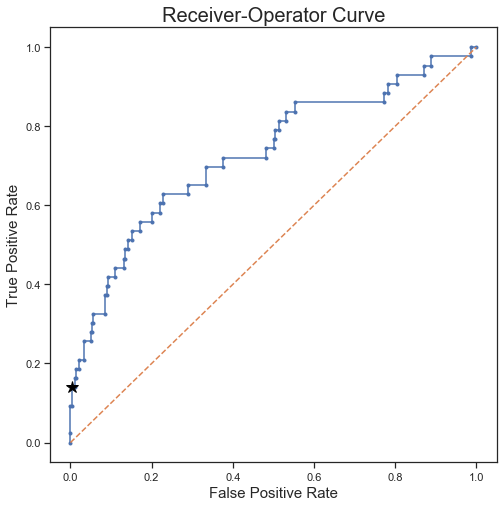

In [44]:
%local

FPR = [x["values"][0] for x in ROC.fpr]
TPR = [x["values"][0] for x in ROC.tpr]

ax, fig = plt.subplots(figsize=(8,8))
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Receiver-Operator Curve", fontsize=20)
plt.plot(FPR, TPR, marker='.')
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# our model
(tn, fp, fn, tp)=(302, 1, 37, 6)
plt.plot([fp/(fp+tn)],[tp/(tp+fn)], color='black', marker='*', markersize=12)

Our final model is represented by the black star on the above plot.

* Area under ROC. 

It should be above 0.5, which is the AUC of a "dummy" model. A model with no skill is represented by the dashed line. It corresponds to a diagonal line from the bottom left of the plot to the top right. 

 The closer the AUC is to 1 (perfect model), the better.

In [30]:
print("Area under ROC curve: "+ str(metrics.roc_auc_score(test_y.values, scores[:,1])))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Area under ROC curve: 0.7291426817100315

ROC curves are more appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets, which is our case here. So let's plot the precision-recall curve. 

__Precision vs Recall__

Precision is the ratio `tp / (tp + fp)` where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier *not to label as positive a sample that is negative*. It is also referred to as the positive predictive value.

Recall is the ratio `tp / (tp + fn)` where tp is the number of true positives as above and fn the number of false negatives. The recall is intuitively the ability of the classifier to *find all the positive samples*. It is also referred to as sensitivity.

The precision recall curve allows us to visualize how both metrics evolve for different thresholds. A perfect classifier could have both precision and recall equal to 1, but in practice a compromise has to be found.

In [31]:
precision, recall, thresholds = metrics.precision_recall_curve(test_y, scores[:,1])

# Data transformation

points2 = np.zeros((precision.shape[0],2))
points2[:,0]=precision
points2[:,1]=recall

dff2 = map(lambda x: (Vectors.dense(x[0]), Vectors.dense(x[1])), points2)
mydf2 = spark.createDataFrame(dff2,schema=["precision", "recall"])
#mydf.show(10)

mydf2.createOrReplaceTempView("PRC")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
%%sql -o PRC --maxrows -1
SELECT * FROM PRC

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

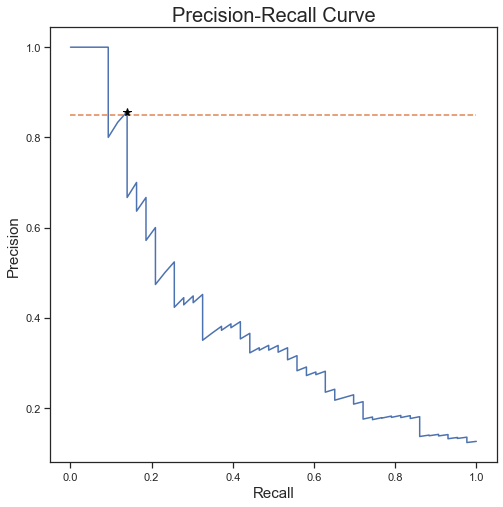

In [43]:
%local

precision = [x["values"][0] for x in PRC.precision]
recall = [x["values"][0] for x in PRC.recall]

ax, fig = plt.subplots(figsize=(8,8))
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)
plt.title("Precision-Recall Curve", fontsize=20)
plt.plot(recall, precision)
# plot no skill
plt.plot([0, 1], [0.85, 0.85], linestyle='--')
plt.plot([6/(6+37)],[6/7], color='black', marker='*', markersize=8)

Note : The no-skill line is defined by the total number of positive cases divide by the total number of positive and negative cases. Points above this line show learning, or "skill". With our final model choice, we are in the skilled zone, it is the black star above.

* Area under Precision-Recall curve

The AUC under PR curve should be compared to n_positive/(n_positive+n_negative) in the original dataset, id est fraction of positive samples in the dataset. Here it is 0.14.

In [34]:
print("Area under Precision/Recall curve: "+str(metrics.average_precision_score(test_y.values, scores[:,1])))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Area under Precision/Recall curve: 0.4008617143054059

## 7. Save your model for future use

__Take a look at parameters and hyperparameters__

In [35]:
# hyperparameters of the model
hp=model.get_params()
print(hp)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 2, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 1e-05, 'verbose': 0, 'warm_start': False}

In [36]:
# how to transfer hyperparameters to another class
logReg2=linear_model.LogisticRegression().set_params(**hp)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
# parameters
print("Parameters for chosen features")
print(model.coef_)
print("Intercept")
print(model.intercept_)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Parameters for chosen features
[[ 0.00212649  0.4402351  -0.022415    0.05987647  0.0391706  -0.08033731]]
Intercept
[-5.98505789]

__Save your model with Joblib__

In [38]:
dump(model, '/tmp/saved_model.joblib') 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['/tmp/saved_model.joblib']

In [39]:
saved_model = load('/tmp/saved_model.joblib') 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
# Test it : you should get the same result as in the previous cell
test_pred2 = saved_model.predict(test_x)
saved_model.score(test_x, test_y)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.8901734104046243

## What you've learned

Congratulations!

In this notebook you have seen how to:
* fetch sample data from Db2 using PySpark
* use sklearn to build a logistic regression 
* deploy a classic ML workflow from data exploration to model assessment
* save your model for future use - in a Python UDF function for example.

____ 
## Authors

Eva Feillet - ML intern, IBM Cloud and Cognitive Software, Böblingen, Germany

__Licence__
 --> to add